In [190]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import f1_score
import joblib



In [191]:
# List files in the data directory to check the correct filename
print(os.getcwd())
# __file__ is not defined in Jupyter notebooks; use os.getcwd() instead
dir_path = os.getcwd()

print("Current Directory:", dir_path)
dir_path = dir_path.replace('src\\kepler', 'data')
print("Data Directory:", dir_path)
df = pd.read_csv(dir_path + '/cumulative_final_2025.10.03.csv')


c:\Users\downe\RightGoodProgrammers\src\kepler
Current Directory: c:\Users\downe\RightGoodProgrammers\src\kepler
Data Directory: c:\Users\downe\RightGoodProgrammers\data


In [192]:

# Separate features and target
target_cols = ['koi_disposition_CANDIDATE', 'koi_disposition_CONFIRMED', 'koi_disposition_FALSE POSITIVE']
y_single = df[target_cols].idxmax(axis=1) \
              .str.replace('koi_disposition_', '') \
              .str.strip()
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=y_single)
X_train = train_df.drop(columns=target_cols)
y_train = train_df[target_cols]
X_test = test_df.drop(columns=target_cols)
y_test = test_df[target_cols]

# Print shapes to verify split
print("Training shapes:", X_train.shape, y_train.shape)
print("Testing shapes:", X_test.shape, y_test.shape)

Training shapes: (6694, 32) (6694, 3)
Testing shapes: (2870, 32) (2870, 3)


In [193]:

# Initialize scaler if it doesnt exist
for file in os.listdir(dir_path.replace('data', 'models')):
    print(file)
    if 'keplerscaler' in file:
        scaler = joblib.load(os.path.join(dir_path.replace('data', 'models'), file))
        break
    else:
        scaler = StandardScaler()

# Fit and transform training data (learns mean and std)
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data (using training mean/std)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Show before/after scaling for first feature
print("Before scaling:")
print(f"Mean: {X_train.iloc[:,0].mean():.2f}")
print(f"Std: {X_train.iloc[:,0].std():.2f}")

print("\nAfter scaling:")
print(f"Mean: {X_train_scaled.iloc[:,0].mean():.2f}")
print(f"Std: {X_train_scaled.iloc[:,0].std():.2f}")

confusion_matrix.png
k2panda_model.pkl
toiscaler.joblib
Before scaling:
Mean: 0.48
Std: 0.48

After scaling:
Mean: -0.00
Std: 1.00


In [194]:
# convert one-hot DataFrame -> single string label -> integer codes
y_train_single = y_train.idxmax(axis=1).str.replace('koi_disposition_', '').str.strip()
y_test_single  = y_test.idxmax(axis=1).str.replace('koi_disposition_', '').str.strip()
##encode labels
for filename in os.listdir(dir_path.replace('data', 'models')):
    if 'label_encoder.joblib' in filename:
        le = joblib.load(dir_path.replace('data', 'models') + '//' + filename)
        break
    else:
        le = LabelEncoder()
        
y_train_enc = le.fit_transform(y_train_single)
y_test_enc  = le.transform(y_test_single)

print("Classes:", le.classes_)
print("Training label distribution:\n", pd.Series(y_train_enc).value_counts())

Classes: ['CANDIDATE' 'CONFIRMED' 'FALSE POSITIVE']
Training label distribution:
 2    3387
1    1922
0    1385
Name: count, dtype: int64


In [195]:
number_of_trees = [50, 100, 200, 300, 400, 500]
best_f1 = 0
best_rf = None
best_pred = None  # store predictions of best model

for filename in os.listdir(dir_path.replace('data', 'models')):
    if 'kepler_rf_best' in filename:
        # Load existing model
        best_rf = joblib.load(os.path.join(dir_path.replace('data', 'models'), filename))
        y_pred = best_rf.predict(X_test_scaled)
        best_f1 = f1_score(y_test_enc, y_pred, average='weighted')
        best_pred = y_pred
        print(f"Loaded existing model with F1 score: {best_f1:.4f}")
        break
else:
    # If no model found, train new ones
    for n in number_of_trees:
        rf = RandomForestClassifier(n_estimators=n, random_state=42)
        rf.fit(X_train_scaled, y_train_enc)

        y_pred = rf.predict(X_test_scaled)
        f1 = f1_score(y_test_enc, y_pred, average='weighted')
        print(f"F1 score for {n} trees: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_rf = rf
            best_pred = y_pred

print(f"Best F1 score: {best_f1:.4f}")
print("First 5 predictions:\n", best_pred[:5])


F1 score for 50 trees: 0.9159
F1 score for 100 trees: 0.9193
F1 score for 200 trees: 0.9179
F1 score for 300 trees: 0.9183
F1 score for 400 trees: 0.9194
F1 score for 500 trees: 0.9204
Best F1 score: 0.9204
First 5 predictions:
 [1 2 1 2 1]


Prediction Accuracy: 92.06%


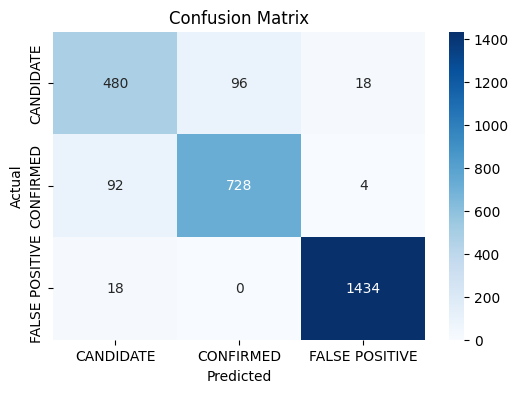

<Figure size 640x480 with 0 Axes>

In [196]:
y_pred = best_rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test_enc, y_pred)
print(f'Prediction Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plt.savefig(dir_path.replace('data', 'models') + '/confusion_matrix.png')


In [197]:
# save best model and label encoder and scaler
current_dir = os.getcwd()
model_dir = current_dir.replace('src\\kepler', 'models\\kepler')
joblib.dump(best_rf, model_dir + 'kepler_rf_best.pkl')

['c:\\Users\\downe\\RightGoodProgrammers\\models\\keplerkepler_rf_best.pkl']